# set up

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
if sys.platform == 'linux':
    sys.path.append("/home/qix/MultiNeuronGLM")
else:
    sys.path.append("D:/Github/MultiNeuronGLM")

In [2]:
import pandas as pd
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
# sns.set_theme()
sns.set_theme(style="white")
# sns.set_style('whitegrid')

from scipy.stats import wilcoxon
from scipy.stats import ranksums
from sklearn.model_selection import KFold

In [3]:
# Load selected group_id
import pickle
with open('group_id_all_a_c/membership.pickle', 'rb') as handle:
    membership = pickle.load(handle)
with open('group_id_all_a_c/condition_ids.pickle', 'rb') as handle:
    condition_ids = pickle.load(handle)

In [4]:
# Load data
start_time = 0.0
end_time = 0.50
padding = 0.3
V1 = Allen_dataset(fps=1000,
                   start_time=start_time, 
                   end_time=end_time,
                   padding=padding,
#                    orientation=[0],
                   session_id=757216464,
                   selected_probes=['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF'],
#                    temporal_frequency=[1,2,4],
                   stimulus_condition_id=[275, 277, 246, 255, 272, 248, 283, 266, 274, 276, 286, 271, 268, 270],
#                    stimulus_condition_id=[246, 247, 248, 249, 250, 251, 252, 253, 255, 256, 257, 258, 259, 260, 261, 
#                                           262, 263, 264, 265, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 277,
#                                           278, 279, 280, 281, 282, 283, 284, 285, 286, 270],
                   stimulus_name='drifting_gratings')

# V1.get_lfp()
# V1.remove_padding(padding)
V1.get_trial_metric_per_unit_per_trial()
# V1.get_trial_metric_per_unit_per_trial(metric_type='spike_times')
V1.get_running(method="mine")

/home/qix/anaconda3/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/stimulus_table/naming_utilities.py:154: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  movie_rows = table[stim_colname].str.contains(movie_re, na=False)
/home/qix/anaconda3/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1315: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


# Fit single neuron level coupling

## Select which neurons to use

In [10]:
### Get the id of neurons that are classified as CROSS-POP and being select in cross-pop in at least FIVE conditions
stimulus_condition_id = [275, 277, 246, 255, 272, 248, 283, 266, 274, 276, 286, 271, 268, 270]
cross_pop_list_all = {}
probe_list = V1.selected_probes
for target_probe in probe_list:
    cross_pop_list = []
    cross_pop_conditions = {}
    for neuron in membership[0].index:
        if membership[1].loc[neuron]['probe'] == target_probe:
            for i, member in enumerate(membership):
                if member.loc[neuron]['group_id'] == 0:
                    if condition_ids[i] in stimulus_condition_id:
                        if neuron not in cross_pop_conditions:
                            cross_pop_list.append(neuron)
                            cross_pop_conditions[neuron] = [condition_ids[i]]
                        else:
                            cross_pop_conditions[neuron].append(condition_ids[i])
    major_cross_pop_list = []
    for neuron in cross_pop_list:
        if len(cross_pop_conditions[neuron])>= 7:
            major_cross_pop_list.append(neuron)
    cross_pop_list_all[target_probe] = major_cross_pop_list

In [8]:
### Get the id of ALL neurons
stimulus_condition_id = [275, 277, 246, 255, 272, 248, 283, 266, 274, 276, 286, 271, 268, 270]
cross_pop_list_all = {}
probe_list = V1.selected_probes
for target_probe in probe_list:
    cross_pop_list = []
    cross_pop_conditions = {}
    for neuron in membership[0].index:
        if membership[1].loc[neuron]['probe'] == target_probe:
            for i, member in enumerate(membership):
                if member.loc[neuron]['group_id'] >= 0:
                    if condition_ids[i] in stimulus_condition_id:
                        if neuron not in cross_pop_conditions:
                            cross_pop_list.append(neuron)
                            cross_pop_conditions[neuron] = [condition_ids[i]]
                        else:
                            cross_pop_conditions[neuron].append(condition_ids[i])
    major_cross_pop_list = []
    for neuron in cross_pop_list:
        if len(cross_pop_conditions[neuron])>= 7:
            major_cross_pop_list.append(neuron)
    cross_pop_list_all[target_probe] = major_cross_pop_list

In [11]:
cross_pop_list_all

{'probeA': [951815091,
  951815126,
  951815173,
  951815207,
  951815269,
  951815239,
  951815231,
  951815250,
  951815403,
  951815361,
  951815453,
  951815699,
  951815816],
 'probeB': [951807228,
  951807290,
  951807276,
  951807333,
  951807310,
  951807373,
  951807379,
  951807411,
  951807479,
  951807531,
  951807511,
  951807587,
  951807553,
  951807673,
  951807742,
  951807941,
  951807973],
 'probeC': [951800909,
  951800877,
  951801070,
  951801053,
  951801108,
  951801206,
  951801302,
  951801369,
  951801532,
  951801559,
  951801604,
  951801627,
  951801755,
  951801696,
  951801892,
  951801907,
  951802070],
 'probeD': [951810863,
  951810983,
  951811026,
  951811015,
  951811152,
  951811141,
  951812394,
  951811203,
  951811282,
  951811389,
  951811873],
 'probeE': [951819135,
  951819151,
  951819264,
  951819298,
  951819601,
  951819593,
  951819743,
  951819836],
 'probeF': [951803932,
  951804056,
  951804050,
  951804082,
  951804062,
  951804144,

In [12]:
for key, value in cross_pop_list_all.items():
    print(f"{key}: {len(value)}")

probeA: 13
probeB: 17
probeC: 17
probeD: 11
probeE: 8
probeF: 9


In [13]:
# Must run before going to next section
spike_train_ind_dict = {}
for target_probe in probe_list:
    for neuron in cross_pop_list_all[target_probe]:
        # Get spike train of the neuron first
        spike_train_ind = np.zeros((V1.nt+V1.npadding, V1.spike_train.shape[1]))
        for itrial in range(V1.spike_train.shape[1]):
            spike_train_ind[:,itrial] = V1.spike_train.loc[neuron, V1.spike_train.columns[itrial]]
        spike_train_ind_dict[neuron] = spike_train_ind


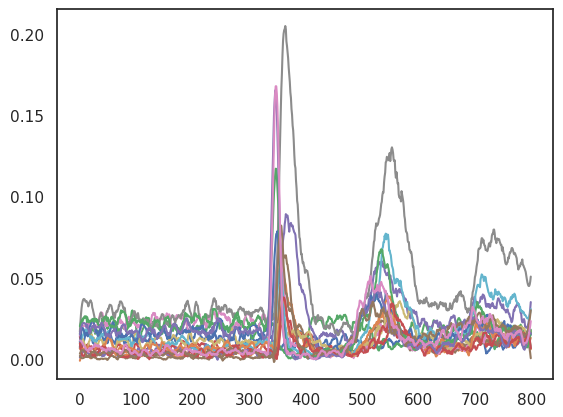

In [32]:
from scipy.signal import savgol_filter

for neuron in cross_pop_list_all['probeC']:
    smoothed_spike_train = savgol_filter(spike_train_ind_dict[neuron].mean(axis=1), window_length=20, polyorder=3)
    plt.plot(smoothed_spike_train)
    

## Example for one neuron

In [8]:
neuron = 951810863
max_iter = 10
tau = 15
coupling_filter_params = {'peaks_max':20.2, 'num':3, 'nonlinear':0.5}
num_basis_baseline = 20
penalty = 1e2

### Stationary
select_trials = V1.stationary_trial_index
model_stationary = GLM.PP_GLM(dataset=V1, 
                       select_trials=select_trials, 
                       membership=membership, 
                       condition_ids=condition_ids)
model_stationary.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=False)
for j, input_probe in enumerate(probe_list):
    for input_neuron in cross_pop_list_all[input_probe]:
        spike_train_ind = spike_train_ind_dict[input_neuron]
        model_stationary.add_effect('coupling', spike_train_ind, 
                                    **coupling_filter_params, apply_no_penalty=True)
model_stationary.add_effect('trial_coef')
model_stationary.fit(spike_train_ind, 
                       method='mine', 
                       verbose=False, 
                       penalty=penalty, 
                       no_penalty_term_penalty=1e0)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-22.555643395602857


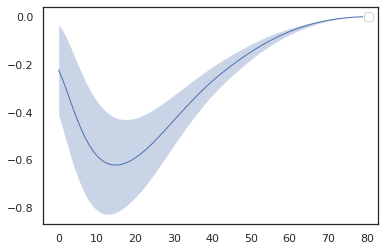

In [103]:
to_look = 1
GLM.plot_GLM_one_effect(model_stationary, to_look)
print(np.sum(model_stationary.get_filter()[to_look]))

## Cross-validation to find best penalty

In [89]:
penalty = 1e2
nfold = 5

from collections import defaultdict
strength_stationary = defaultdict(list)
strength_running = defaultdict(list)

total_params_stationary = 0
total_nll_stationary = 0
total_params_running = 0
total_nll_running = 0

max_iter = 10
tau = 15
# coupling_filter_params = {'peaks_max':20.2, 'num':3, 'nonlinear':0.5}
coupling_filter_params = {'peaks_max':50, 'num':6, 'nonlinear':0.3}
num_basis_baseline = 20

coupling_filter_params1 = {'peaks_max':50, 'num':6, 'nonlinear':0.3}
stationary_cv = []
running_cv = []

for i, target_probe in enumerate(probe_list):
    for neuron in tqdm(cross_pop_list_all[target_probe]):
        
        ### Stationary
        kf = KFold(n_splits=nfold)
        ntrial = V1.stationary_trial_index.sum()
        ntrial_tot = len(V1.stationary_trial_index)
        for ifold, (train_index, test_index) in enumerate(kf.split(np.ones(ntrial))):
            trial_num = np.where(V1.stationary_trial_index==True)[0]
            training_trials = np.array( [False]*ntrial_tot )
            training_trials[trial_num[train_index]] = True
            test_trials = np.array( [False]*ntrial_tot )
            test_trials[trial_num[test_index]] = True
            
            model_stationary = GLM.PP_GLM(dataset=V1, 
                                   select_trials=training_trials, 
                                   membership=membership, 
                                   condition_ids=condition_ids)
            model_stationary.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=False)
            for j, input_probe in enumerate(probe_list):
                for input_neuron in cross_pop_list_all[input_probe]:
                    spike_train_ind = spike_train_ind_dict[input_neuron]
                    if neuron!=input_neuron:
                        model_stationary.add_effect('coupling', spike_train_ind, 
                                                    **coupling_filter_params, apply_no_penalty=False)
                    else:
                        model_stationary.add_effect('coupling', spike_train_ind, 
                                                    **coupling_filter_params1, apply_no_penalty=False)
#             model_stationary.add_effect('trial_coef')
            model_stationary.fit(spike_train_ind, 
                                   method='mine', 
                                   verbose=False, 
                                   penalty=penalty, 
                                   no_penalty_term_penalty=1e-2)
            stationary_cv.append( model_stationary.test(test_trials) )
            
        ### Running
        kf = KFold(n_splits=nfold)
        ntrial = V1.running_trial_index.sum()
        ntrial_tot = len(V1.stationary_trial_index)
        for ifold, (train_index, test_index) in enumerate(kf.split(np.ones(ntrial))):
            trial_num = np.where(V1.running_trial_index==True)[0]
            training_trials = np.array( [False]*ntrial_tot )
            training_trials[trial_num[train_index]] = True
            test_trials = np.array( [False]*ntrial_tot )
            test_trials[trial_num[test_index]] = True
            
            model_running = GLM.PP_GLM(dataset=V1, 
                               select_trials=training_trials, 
                               membership=membership, 
                               condition_ids=condition_ids)
            model_running.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=False)
            for j, input_probe in enumerate(probe_list):
                for input_neuron in cross_pop_list_all[input_probe]:
                    spike_train_ind = spike_train_ind_dict[input_neuron]
                    if neuron!=input_neuron:
                        model_running.add_effect('coupling', spike_train_ind, 
                                                    **coupling_filter_params, apply_no_penalty=False)
                    else:
                        model_running.add_effect('coupling', spike_train_ind, 
                                                    **coupling_filter_params1, apply_no_penalty=False)
#             model_running.add_effect('trial_coef')
            model_running.fit(spike_train_ind, 
                               method='mine', 
                               verbose=False, 
                               penalty=penalty, 
                               no_penalty_term_penalty=1e-2)
            running_cv.append( model_running.test(test_trials) )

100%|██████████████████████████████████████| 8/8 [04:33<00:00, 34.20s/it]


In [90]:
np.mean(running_cv+stationary_cv)

760.4443600681844

调参中：调实际数据里的penalty应该多大
选择1e2

```
{
1e0: 1664.415647929977
1e1: 797.2521242138706
5e1: 
1e2: 715.4567998132029
3e2: 760.4443600681844
1e3: 866.7154414025786
```
}

## Ranksums tests

In [227]:
from collections import defaultdict
strength_stationary = defaultdict(list)
strength_running = defaultdict(list)

total_params_stationary = 0
total_nll_stationary = 0
total_params_running = 0
total_nll_running = 0

max_iter = 10
tau = 15
# coupling_filter_params = {'peaks_max':20.2, 'num':3, 'nonlinear':0.5}
coupling_filter_params = {'peaks_max':50, 'num':6, 'nonlinear':0.3}
num_basis_baseline = 20
penalty = 1e2
coupling_filter_params1 = {'peaks_max':50, 'num':6, 'nonlinear':0.3}

for i, target_probe in enumerate(probe_list):
    for neuron in tqdm(cross_pop_list_all[target_probe]):

        ### Stationary
        select_trials = V1.stationary_trial_index
        model_stationary = GLM.PP_GLM(dataset=V1, 
                               select_trials=select_trials, 
                               membership=membership, 
                               condition_ids=condition_ids)
        model_stationary.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=False)
        for j, input_probe in enumerate(probe_list):
            for input_neuron in cross_pop_list_all[input_probe]:
                spike_train_ind = spike_train_ind_dict[input_neuron]
                if neuron!=input_neuron:
                    model_stationary.add_effect('coupling', spike_train_ind, 
                                                **coupling_filter_params, apply_no_penalty=False)
                else:
                    model_stationary.add_effect('coupling', spike_train_ind, 
                                                **coupling_filter_params1, apply_no_penalty=False)
        model_stationary.add_effect('trial_coef')
        spike_train_ind = spike_train_ind_dict[neuron]
        model_stationary.fit(spike_train_ind, 
                               method='mine', 
                               verbose=False, 
                               penalty=penalty, 
                               no_penalty_term_penalty=1e-2)
        filters = model_stationary.get_filter()
        k = 0
        for j, input_probe in enumerate(probe_list):
            for input_neuron in cross_pop_list_all[input_probe]:
                k += 1
                strength = np.sum(filters[k])
                strength_stationary[i,j].append(strength)
        total_params_stationary += len(model_stationary.results.params)
        total_nll_stationary += model_stationary.nll
        
        ### Running
        select_trials = V1.running_trial_index
        model_running = GLM.PP_GLM(dataset=V1, 
                           select_trials=select_trials, 
                           membership=membership, 
                           condition_ids=condition_ids)
        model_running.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=False)
        for j, input_probe in enumerate(probe_list):
            for input_neuron in cross_pop_list_all[input_probe]:
                spike_train_ind = spike_train_ind_dict[input_neuron]
                if neuron!=input_neuron:
                    model_running.add_effect('coupling', spike_train_ind, 
                                                **coupling_filter_params, apply_no_penalty=False)
                else:
                    model_running.add_effect('coupling', spike_train_ind, 
                                                **coupling_filter_params1, apply_no_penalty=False)
        model_running.add_effect('trial_coef')
        spike_train_ind = spike_train_ind_dict[neuron]
        model_running.fit(spike_train_ind, 
                           method='mine', 
                           verbose=False, 
                           penalty=penalty, 
                           no_penalty_term_penalty=1e-2)
        filters = model_running.get_filter()
        k = 0
        for j, input_probe in enumerate(probe_list):
            for input_neuron in cross_pop_list_all[input_probe]:
                k += 1
                strength = np.sum(filters[k])
                strength_running[i,j].append(strength)
        total_params_running += len(model_running.results.params)
        total_nll_running += model_running.nll

100%|████████████████████████████████████| 37/37 [33:05<00:00, 53.67s/it]


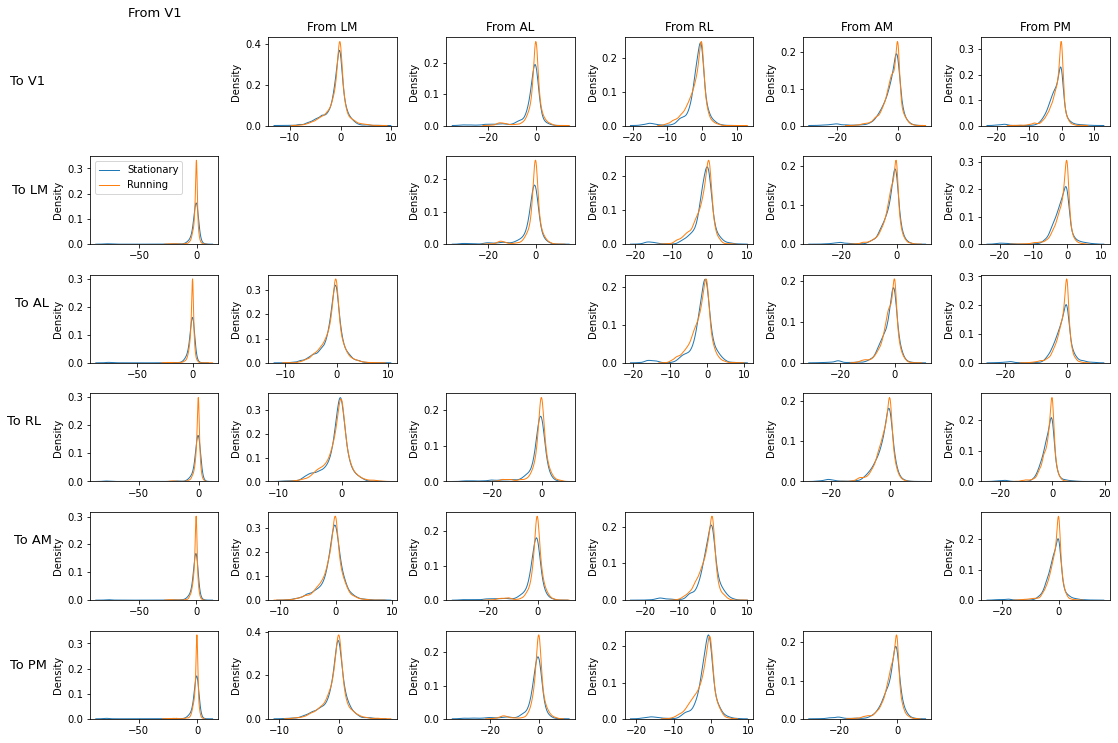

In [260]:
def plot_strength(V1, strength_stationary, strength_running, plot_self=False, filter_amp=20, output=False):
    transfer_ij = {-1:-1, 4:0, 5:1, 0:2, 1:3, 2:4, 3:5}
    probe_list = V1.selected_probes
    name_list = ['V1', 'LM', 'AL', 'RL', 'AM', 'PM']
    fontsize = 15
    filter_length = 0.1
    trial_length = V1.nt

    sns.reset_orig()
    # sns.set_theme()
    if output:
        plt.subplots(figsize=(6.9,4.6))
        SMALL_SIZE = 5
        MEDIUM_SIZE = 7
        BIGGER_SIZE = 8
        BIGGER_LW = 1
        SMALL_LW = 0.75
        utils.use_pdf_plot()
    else:
        plt.subplots(figsize=(15,10))
        BIGGER_SIZE = 15
        MEDIUM_SIZE = 15
        SMALL_SIZE = 10
        BIGGER_LW = 2
        SMALL_LW = 1.5
    
#     plt.subplots(figsize=(15,10))
    for i in range(len(probe_list)):
        for j in range(len(probe_list)):
            i_plot = transfer_ij[i]
            j_plot = transfer_ij[j]
            if i==j and (not plot_self):
                continue
            ax = plt.subplot(6, 6, i*6+j+1, frameon=True)
            filter_index = i_plot,j_plot
    #         print(filter_index)
            
            sns.kdeplot(strength_stationary[i_plot,j_plot], linewidth=1, fill=False)
            sns.kdeplot(strength_running[i_plot,j_plot], linewidth=1, fill=False)
            
            
            plt.tight_layout()
            # plt.grid()
    
    plt.subplot(6, 6, 7)
    plt.legend(["Stationary", "Running"], loc='upper left')
    for i in range(6):
        if i==0:
            plt.subplot(6, 6, 7)
            plt.text(-60, 0.9, f"From {name_list[i]}", fontsize=13)
        else:
            plt.subplot(6, 6, i+1)
            plt.title(f"From {name_list[i]}")
    for i in range(6):
        if i==0:
            plt.subplot(6, 6, 2)
            plt.text(-65, 0.2, f"To {name_list[i]}", fontsize=13)
        else:
            plt.subplot(6, 6, 6*i+1)
            plt.text(-160, 0.2, f"To {name_list[i]}", fontsize=13)
    
plot_strength(V1, strength_stationary, strength_running, output=False)

In [232]:
for i, target_probe in enumerate(probe_list):
    for j, input_probe in enumerate(probe_list):
        res = ranksums( strength_stationary[i,j], strength_running[i,j] )
        if res[1]<=0.99 and i!=j:
            print(f"{input_probe}->{target_probe}: {res[1]}")

probeB->probeA: 1.1214455103130374e-05
probeC->probeA: 2.1052481657061746e-06
probeD->probeA: 0.04487639454016215
probeE->probeA: 1.2472724646245646e-44
probeF->probeA: 9.402348849335479e-06
probeA->probeB: 0.31726315821993334
probeC->probeB: 2.631320866853507e-06
probeD->probeB: 0.8456056970657924
probeE->probeB: 1.60205754629305e-41
probeF->probeB: 0.013503508781325236
probeA->probeC: 0.07695441317888539
probeB->probeC: 9.838188599089602e-16
probeD->probeC: 5.8589616193511984e-05
probeE->probeC: 4.607951185264072e-61
probeF->probeC: 5.4418133294598435e-05
probeA->probeD: 0.2829962870640159
probeB->probeD: 4.503830232696648e-11
probeC->probeD: 0.006589082986095054
probeE->probeD: 1.0980429298012363e-35
probeF->probeD: 0.07091383545993477
probeA->probeE: 0.4225861524990784
probeB->probeE: 0.0005058462686594025
probeC->probeE: 0.02053414056751126
probeD->probeE: 0.700900762548168
probeF->probeE: 8.072384864138988e-06
probeA->probeF: 0.40330167122698213
probeB->probeF: 1.4511621711218166

## ** Ranksums tests (only use cross-pop)

By changing line 47/48, line 83/84, and running the following 2nd and 3rd two code chucks, we can get Pillow method filters and outputs. 

In [63]:
from collections import defaultdict
strength_stationary = defaultdict(list)
strength_running = defaultdict(list)
filters_stationary = defaultdict(list)
filters_running = defaultdict(list)

total_params_stationary = 0
total_nll_stationary = 0
total_params_running = 0
total_nll_running = 0

max_iter = 10
tau = 15
# coupling_filter_params = {'peaks_max':20.2, 'num':3, 'nonlinear':0.5}
coupling_filter_params = {'peaks_max':40, 'num':6, 'nonlinear':0.3}
num_basis_baseline = 20
penalty = 1e2
# coupling_filter_params1 = {'peaks_max':20.2, 'num':3, 'nonlinear':0.5}
coupling_filter_params1 = {'peaks_max':40, 'num':6, 'nonlinear':0.3}

for i, target_probe in enumerate(probe_list):
    for neuron in tqdm(cross_pop_list_all[target_probe]):

        ### Stationary
        select_trials = V1.stationary_trial_index
        model_stationary = GLM.PP_GLM(dataset=V1, 
                               select_trials=select_trials, 
                               membership=membership, 
                               condition_ids=condition_ids)
        model_stationary.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=False)
        for j, input_probe in enumerate(probe_list):
            for input_neuron in cross_pop_list_all[input_probe]:
                spike_train_ind = spike_train_ind_dict[input_neuron]
                if neuron!=input_neuron:
                    model_stationary.add_effect('coupling', spike_train_ind, 
                                                **coupling_filter_params, apply_no_penalty=False)
                else:
                    model_stationary.add_effect('coupling', spike_train_ind, 
                                                **coupling_filter_params1, apply_no_penalty=False)
        model_stationary.add_effect('trial_coef')
        spike_train_ind = spike_train_ind_dict[neuron]
        model_stationary.fit(spike_train_ind, 
                               method='mine', 
                               verbose=False, 
                               penalty=penalty, 
                               no_penalty_term_penalty=1e-2)
        # filters = model_stationary.get_filter()
        filters = model_stationary.get_filter_output()

        k = 0
        for j, input_probe in enumerate(probe_list):
            for input_neuron in cross_pop_list_all[input_probe]:
                k += 1
                strength = np.sum(filters[k])
                strength_stationary[i,j].append(strength)
                filters_stationary[i,j].append(filters[k])
        total_params_stationary += len(model_stationary.results.params)
        total_nll_stationary += model_stationary.nll
        
        ### Running
        select_trials = V1.running_trial_index
        model_running = GLM.PP_GLM(dataset=V1, 
                           select_trials=select_trials, 
                           membership=membership, 
                           condition_ids=condition_ids)
        model_running.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=False)
        for j, input_probe in enumerate(probe_list):
            for input_neuron in cross_pop_list_all[input_probe]:
                spike_train_ind = spike_train_ind_dict[input_neuron]
                if neuron!=input_neuron:
                    model_running.add_effect('coupling', spike_train_ind, 
                                                **coupling_filter_params, apply_no_penalty=False)
                else:
                    model_running.add_effect('coupling', spike_train_ind, 
                                                **coupling_filter_params1, apply_no_penalty=False)
        model_running.add_effect('trial_coef')
        spike_train_ind = spike_train_ind_dict[neuron]
        model_running.fit(spike_train_ind, 
                           method='mine', 
                           verbose=False, 
                           penalty=penalty, 
                           no_penalty_term_penalty=1e-2)
        # filters = model_running.get_filter()
        filters = model_running.get_filter_output()
        
        k = 0
        for j, input_probe in enumerate(probe_list):
            for input_neuron in cross_pop_list_all[input_probe]:
                k += 1
                strength = np.sum(filters[k])
                strength_running[i,j].append(strength)
                filters_running[i,j].append(filters[k])
        total_params_running += len(model_running.results.params)
        total_nll_running += model_running.nll

100%|██████████████████████████████████████| 9/9 [01:28<00:00,  9.86s/it]


/tmp/ipykernel_34252/1251178509.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 6, i*6+j+1, frameon=True)


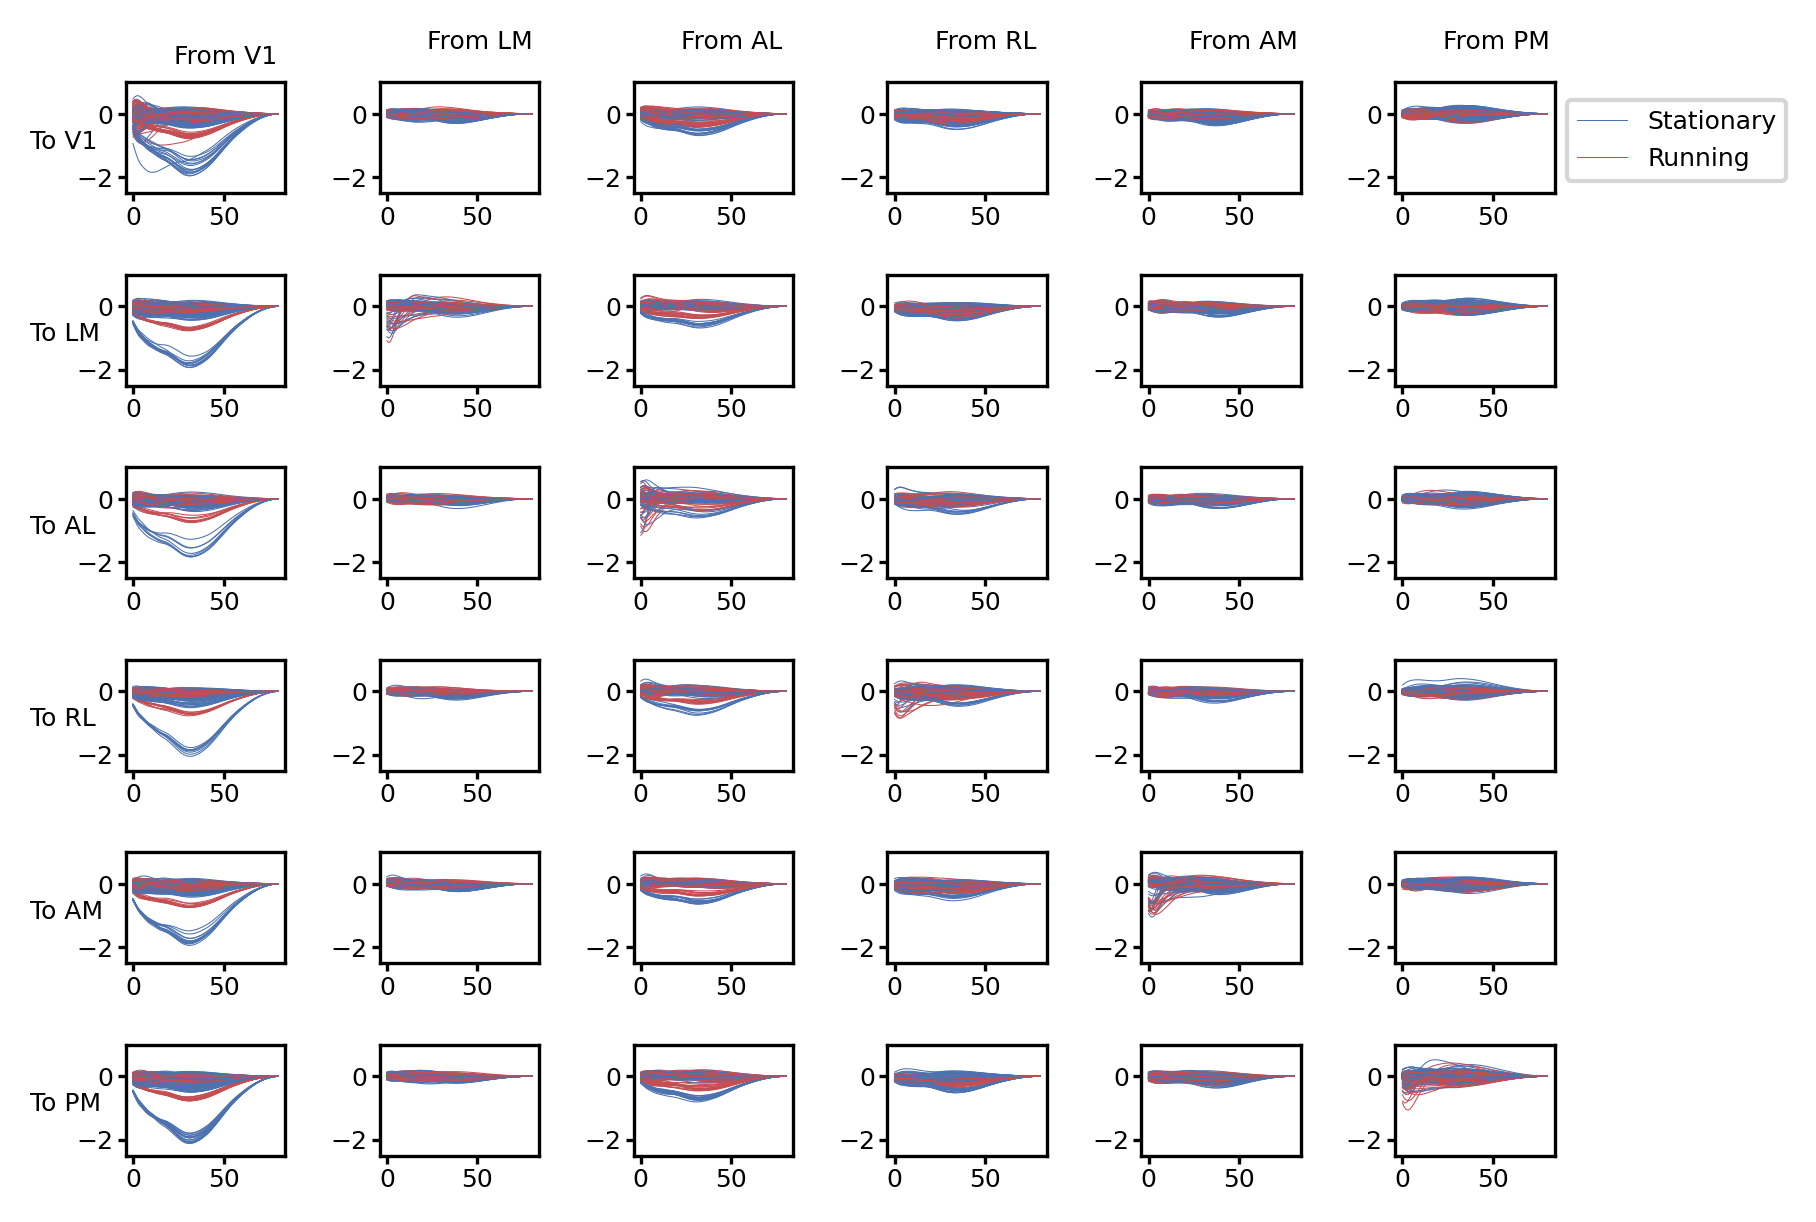

In [62]:
### Plot filters
def plot_filters(V1, filters_stationary, filters_running, plot_self=True, filter_amp=20, output=False):
    utils.use_pdf_plot()
    
    SMALL_SIZE = 5
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 7
    BIGGER_LW = 1
    SMALL_LW = 0.75
    
    transfer_ij = {-1:-1, 4:0, 5:1, 0:2, 1:3, 2:4, 3:5}
    probe_list = V1.selected_probes
    name_list = ['V1', 'LM', 'AL', 'RL', 'AM', 'PM']

#     plt.subplots(figsize=(15,10))
    plt.subplots(figsize=(6.0,4.0), dpi=300)
    for i in range(len(probe_list)):
        for j in range(len(probe_list)):
            i_plot = transfer_ij[i]
            j_plot = transfer_ij[j]
            if i==j and (not plot_self):
                continue
            ax = plt.subplot(6, 6, i*6+j+1, frameon=True)
            filter_index = i_plot,j_plot
    #         print(filter_index)
            
            for i_coupling in range(len(filters_stationary[i_plot,j_plot])):
                if i_coupling%1==0:
                    plt.plot(filters_stationary[i_plot,j_plot][i_coupling], linewidth=0.25, color='b')
                    plt.plot(filters_running[i_plot,j_plot][i_coupling], linewidth=0.25, color='r')
                    plt.ylim([-2.5,1])
    
    ax = plt.subplot(6, 6, 6)
    plt.legend(["Stationary", "Running"], loc='lower left', bbox_to_anchor=(1, 0))
    plt.tight_layout()
    
    for i in range(6):
        if i==0:
            ax = plt.subplot(6, 6, 7)
            plt.text(0.3, 2.9, f"From {name_list[i]}", transform=ax.transAxes, fontsize=MEDIUM_SIZE)
        else:
            ax = plt.subplot(6, 6, i+1)
            plt.text(0.3, 1.3, f"From {name_list[i]}", transform=ax.transAxes, fontsize=MEDIUM_SIZE)
    for i in range(6):
        if i==0:
            ax = plt.subplot(6, 6, 1)
            plt.text(-0.6, 0.4, f"To {name_list[i]}", transform=ax.transAxes, fontsize=MEDIUM_SIZE)
        else:
            ax = plt.subplot(6, 6, 6*i+1)
            plt.text(-0.6, 0.4, f"To {name_list[i]}", transform=ax.transAxes, fontsize=MEDIUM_SIZE)
    
plot_filters(V1, filters_stationary, filters_running, output=False)
plt.savefig('Figures/SupFig/HukFilters.pdf', format='pdf', dpi=300)

/tmp/ipykernel_34252/3193063729.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 6, i*6+j+1, frameon=True)


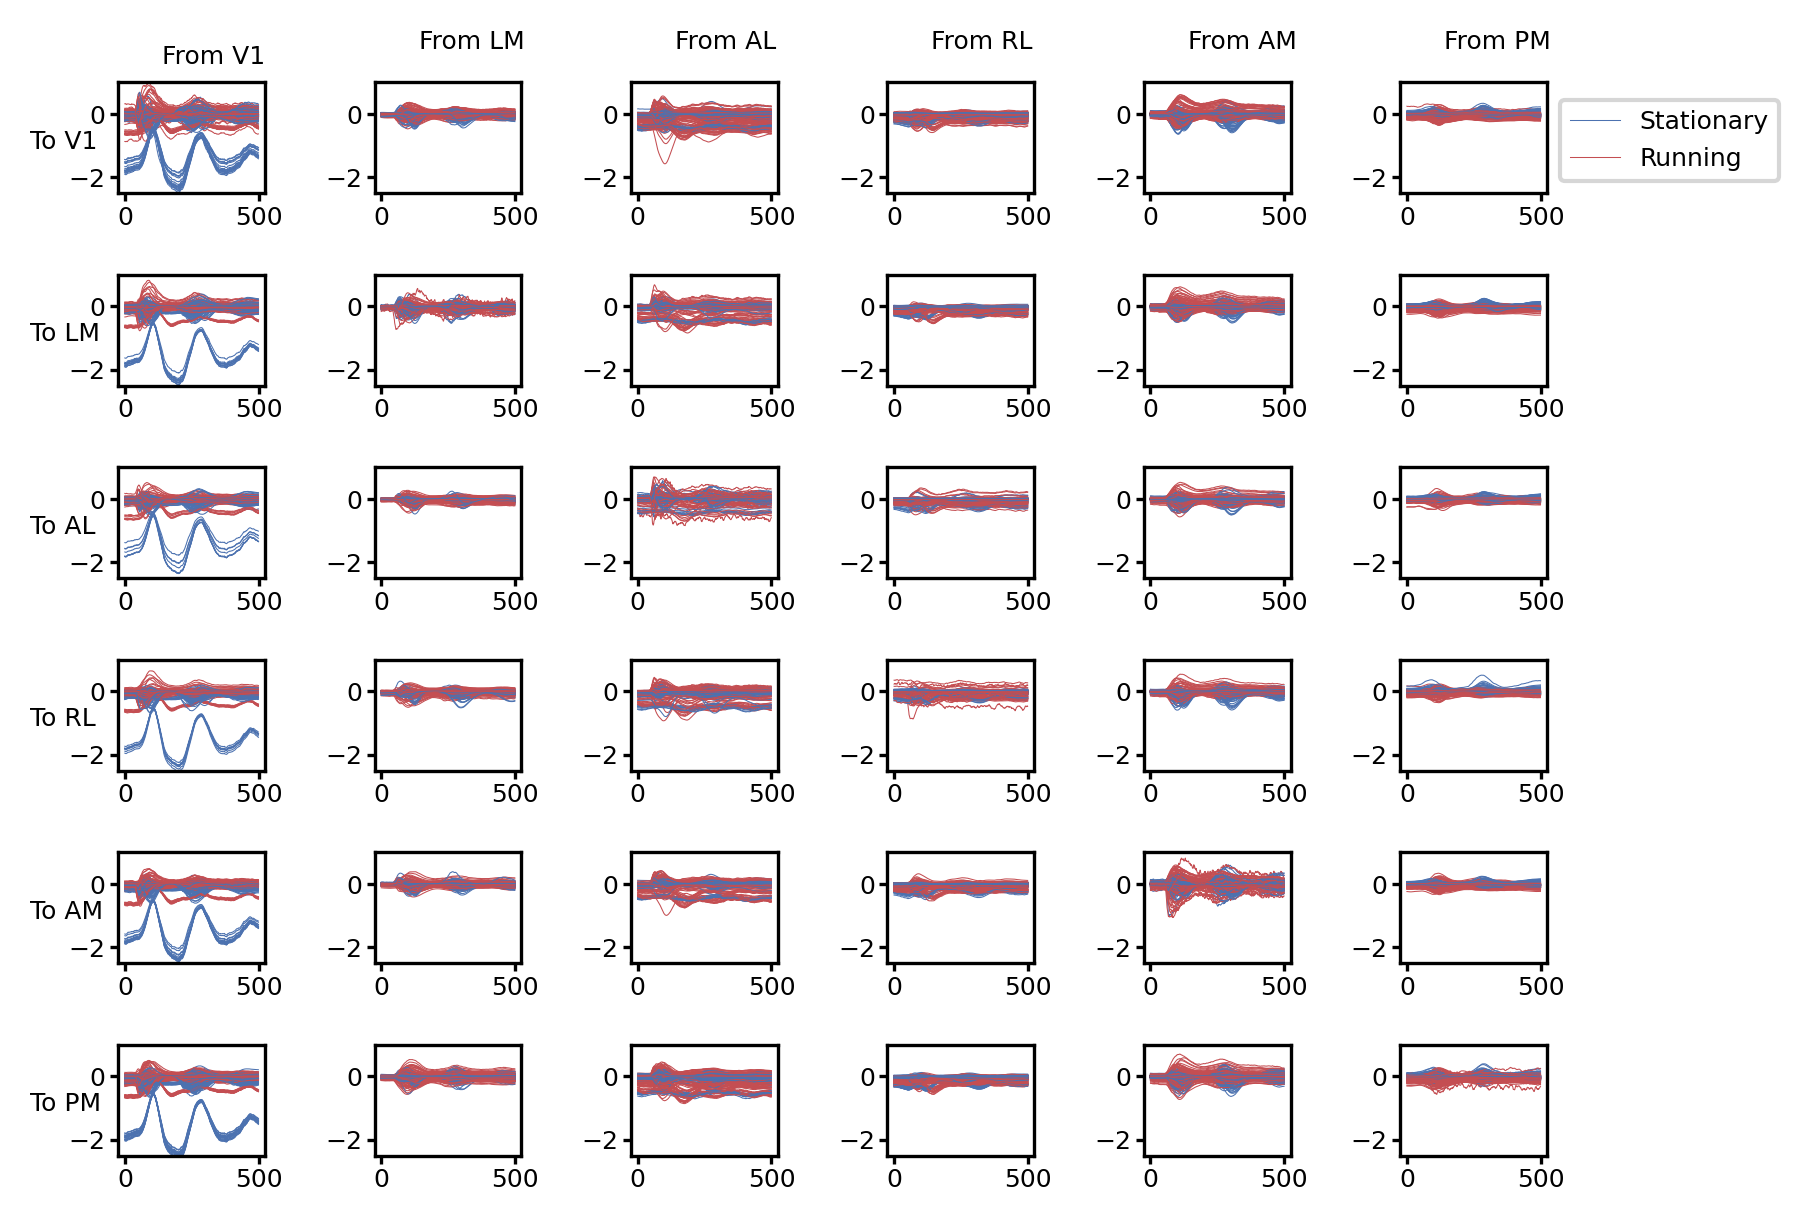

In [64]:
### Plot Outputs
def plot_filters(V1, filters_stationary, filters_running, plot_self=True, filter_amp=20, output=False):
    utils.use_pdf_plot()
    
    SMALL_SIZE = 5
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 7
    BIGGER_LW = 1
    SMALL_LW = 0.75
    
    transfer_ij = {-1:-1, 4:0, 5:1, 0:2, 1:3, 2:4, 3:5}
    probe_list = V1.selected_probes
    name_list = ['V1', 'LM', 'AL', 'RL', 'AM', 'PM']

#     plt.subplots(figsize=(15,10))
    plt.subplots(figsize=(6.0,4.0), dpi=300)
    for i in range(len(probe_list)):
        for j in range(len(probe_list)):
            i_plot = transfer_ij[i]
            j_plot = transfer_ij[j]
            if i==j and (not plot_self):
                continue
            ax = plt.subplot(6, 6, i*6+j+1, frameon=True)
            filter_index = i_plot,j_plot
    #         print(filter_index)
            
            for i_coupling in range(len(filters_stationary[i_plot,j_plot])):
                if i_coupling%1==0:
                    plt.plot(filters_stationary[i_plot,j_plot][i_coupling], linewidth=0.25, color='b')
                    plt.plot(filters_running[i_plot,j_plot][i_coupling], linewidth=0.25, color='r')
                    plt.ylim([-2.5,1])
    
    ax = plt.subplot(6, 6, 6)
    plt.legend(["Stationary", "Running"], loc='lower left', bbox_to_anchor=(1, 0))
    plt.tight_layout()
    
    for i in range(6):
        if i==0:
            ax = plt.subplot(6, 6, 7)
            plt.text(0.3, 2.9, f"From {name_list[i]}", transform=ax.transAxes, fontsize=MEDIUM_SIZE)
        else:
            ax = plt.subplot(6, 6, i+1)
            plt.text(0.3, 1.3, f"From {name_list[i]}", transform=ax.transAxes, fontsize=MEDIUM_SIZE)
    for i in range(6):
        if i==0:
            ax = plt.subplot(6, 6, 1)
            plt.text(-0.6, 0.4, f"To {name_list[i]}", transform=ax.transAxes, fontsize=MEDIUM_SIZE)
        else:
            ax = plt.subplot(6, 6, 6*i+1)
            plt.text(-0.6, 0.4, f"To {name_list[i]}", transform=ax.transAxes, fontsize=MEDIUM_SIZE)
    
plot_filters(V1, filters_stationary, filters_running, output=False)
plt.savefig('Figures/SupFig/HukOutputs.pdf', format='pdf', dpi=300)

---

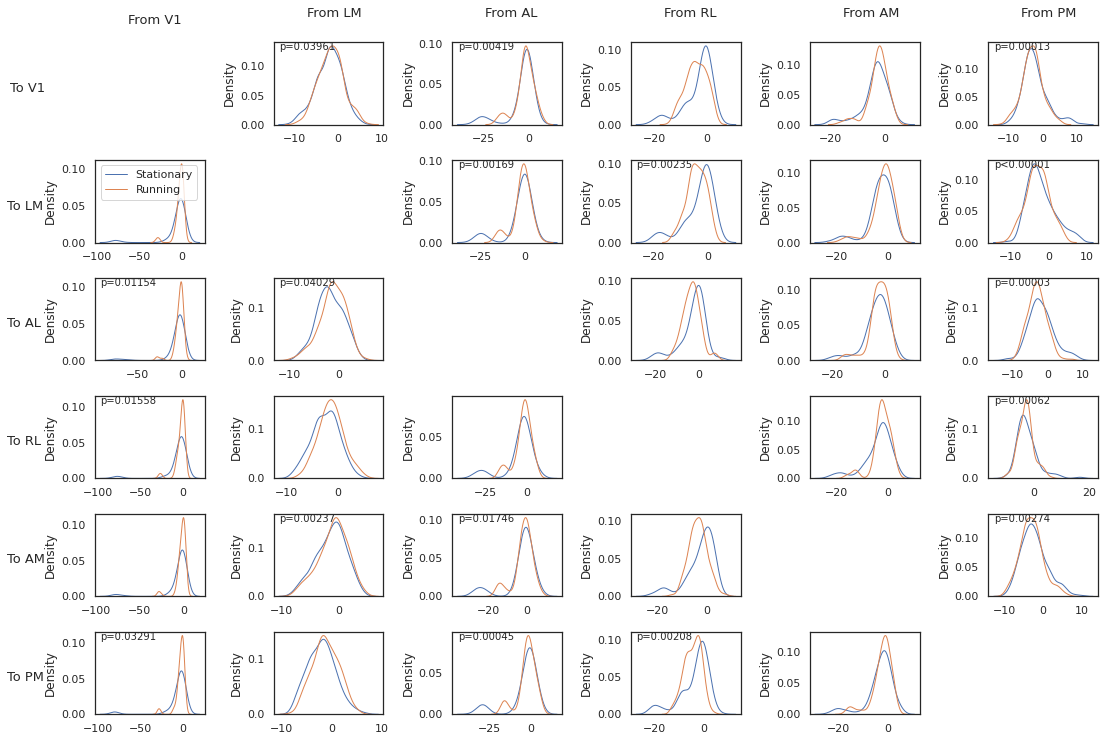

In [16]:
def plot_strength(V1, strength_stationary, strength_running, plot_self=False, filter_amp=20, output=False):
    transfer_ij = {-1:-1, 4:0, 5:1, 0:2, 1:3, 2:4, 3:5}
    probe_list = V1.selected_probes
    name_list = ['V1', 'LM', 'AL', 'RL', 'AM', 'PM']

    plt.subplots(figsize=(15,10))
    for i in range(len(probe_list)):
        for j in range(len(probe_list)):
            i_plot = transfer_ij[i]
            j_plot = transfer_ij[j]
            if i==j and (not plot_self):
                continue
            ax = plt.subplot(6, 6, i*6+j+1, frameon=True)
            filter_index = i_plot,j_plot
    #         print(filter_index)
            
            sns.kdeplot(strength_stationary[i_plot,j_plot], linewidth=1, fill=False)
            sns.kdeplot(strength_running[i_plot,j_plot], linewidth=1, fill=False)
            
            res = ranksums( strength_stationary[i,j], strength_running[i,j] )
            if res[1]<=0.05:
                if res[1]<=1e-5:
                    plt.text(0.05, 0.9, f"p<{1e-5:.5f}", transform=ax.transAxes, fontsize=10)
                else:
                    plt.text(0.05, 0.9, f"p={res[1]:.5f}", transform=ax.transAxes, fontsize=10)
            plt.tight_layout()
            # plt.grid()
    
    ax = plt.subplot(6, 6, 7)
    plt.legend(["Stationary", "Running"], loc='upper left')
    for i in range(6):
        if i==0:
            ax = plt.subplot(6, 6, 7)
            plt.text(0.3, 2.65, f"From {name_list[i]}", transform=ax.transAxes, fontsize=13)
        else:
            ax = plt.subplot(6, 6, i+1)
            plt.text(0.3, 1.3, f"From {name_list[i]}", transform=ax.transAxes, fontsize=13)
    for i in range(6):
        if i==0:
            ax = plt.subplot(6, 6, 2)
            plt.text(-2.4, 0.4, f"To {name_list[i]}", transform=ax.transAxes, fontsize=13)
        else:
            ax = plt.subplot(6, 6, 6*i+1)
            plt.text(-0.8, 0.4, f"To {name_list[i]}", transform=ax.transAxes, fontsize=13)
    
plot_strength(V1, strength_stationary, strength_running, output=False)

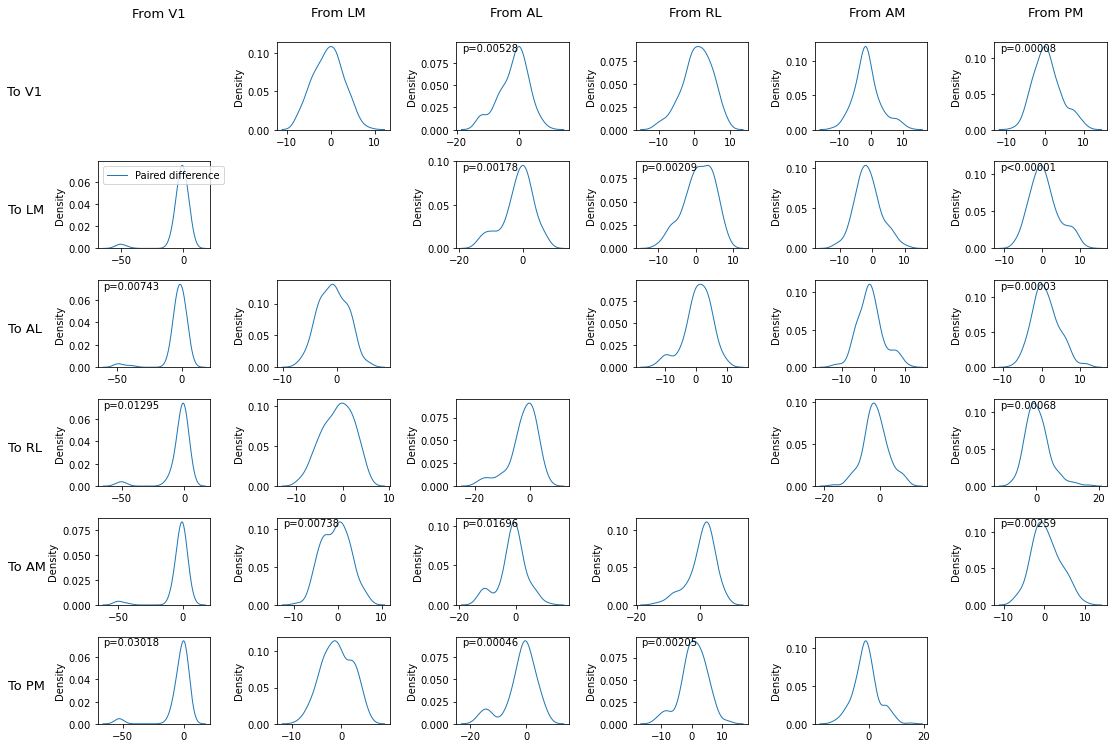

In [21]:
def plot_strength(V1, strength_stationary, strength_running, plot_self=False, filter_amp=20, output=False):
    transfer_ij = {-1:-1, 4:0, 5:1, 0:2, 1:3, 2:4, 3:5}
    probe_list = V1.selected_probes
    name_list = ['V1', 'LM', 'AL', 'RL', 'AM', 'PM']
    fontsize = 15
    filter_length = 0.1
    trial_length = V1.nt

    sns.reset_orig()
    # sns.set_theme()
    if output:
        plt.subplots(figsize=(6.9,4.6))
        SMALL_SIZE = 5
        MEDIUM_SIZE = 7
        BIGGER_SIZE = 8
        BIGGER_LW = 1
        SMALL_LW = 0.75
        utils.use_pdf_plot()
    else:
        plt.subplots(figsize=(15,10))
        BIGGER_SIZE = 15
        MEDIUM_SIZE = 15
        SMALL_SIZE = 10
        BIGGER_LW = 2
        SMALL_LW = 1.5
    
#     plt.subplots(figsize=(15,10))
    for i in range(len(probe_list)):
        for j in range(len(probe_list)):
            i_plot = transfer_ij[i]
            j_plot = transfer_ij[j]
            if i==j and (not plot_self):
                continue
            ax = plt.subplot(6, 6, i*6+j+1, frameon=True)
            filter_index = i_plot,j_plot
    #         print(filter_index)
            
            sns.kdeplot(np.array(strength_stationary[i_plot,j_plot])-np.array(strength_running[i_plot,j_plot]), 
                        linewidth=1, fill=False)
            
            res = ranksums( strength_stationary[i,j], strength_running[i,j] )
            if res[1]<=0.05:
                if res[1]<=1e-5:
                    plt.text(0.05, 0.9, f"p<{1e-5:.5f}", transform=ax.transAxes, fontsize=10)
                else:
                    plt.text(0.05, 0.9, f"p={res[1]:.5f}", transform=ax.transAxes, fontsize=10)
            plt.tight_layout()
            # plt.grid()
    
    ax = plt.subplot(6, 6, 7)
    plt.legend(["Paired difference"], loc='upper left')
    for i in range(6):
        if i==0:
            ax = plt.subplot(6, 6, 7)
            plt.text(0.3, 2.65, f"From {name_list[i]}", transform=ax.transAxes, fontsize=13)
        else:
            ax = plt.subplot(6, 6, i+1)
            plt.text(0.3, 1.3, f"From {name_list[i]}", transform=ax.transAxes, fontsize=13)
    for i in range(6):
        if i==0:
            ax = plt.subplot(6, 6, 2)
            plt.text(-2.4, 0.4, f"To {name_list[i]}", transform=ax.transAxes, fontsize=13)
        else:
            ax = plt.subplot(6, 6, 6*i+1)
            plt.text(-0.8, 0.4, f"To {name_list[i]}", transform=ax.transAxes, fontsize=13)
    
plot_strength(V1, strength_stationary, strength_running, output=False)

In [28]:
for i, target_probe in enumerate(probe_list):
    for j, input_probe in enumerate(probe_list):
        res = ranksums( strength_stationary[i,j], strength_running[i,j] )
        if res[1]<=0.05 and i!=j:
            print(f"{input_probe}->{target_probe}: {res[1]:.5f}")

probeC->probeA: 0.00528
probeF->probeA: 0.00008
probeC->probeB: 0.00178
probeD->probeB: 0.00209
probeF->probeB: 0.00001
probeA->probeC: 0.00743
probeF->probeC: 0.00003
probeA->probeD: 0.01295
probeF->probeD: 0.00068
probeB->probeE: 0.00738
probeC->probeE: 0.01696
probeF->probeE: 0.00259
probeA->probeF: 0.03018
probeC->probeF: 0.00046
probeD->probeF: 0.00205


# With time warping

In [108]:
### Get time shifts (time warping parameters)
fix_shifts_stationary_all = {}
fix_shifts_running_all = {}


max_iter = 10
tau = 15
coupling_filter_params = {'peaks_max':10, 'num':3, 'nonlinear':0.5}
num_basis_baseline = 20
penalty = 5e-1

for target_probe in tqdm(probe_list):

    ########## Nothing need to be changed below
    select_trials = V1.stationary_trial_index
    model_stationary = GLM.PP_GLM(dataset=V1, 
                       select_trials=select_trials, 
                       membership=membership, 
                       condition_ids=condition_ids)
    model_stationary.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=True)
    for j, input_probe in enumerate(probe_list):
        model_stationary.add_effect('coupling', probe_list[j], **coupling_filter_params, apply_no_penalty=True)
    model_stationary.add_effect('trial_coef')
    # model_stationary.fit_time_warping_baseline(spike_train_ind[:,select_trials], method='mine', verbose=False, 
    #                                            max_iter=max_iter, penalty=penalty)
    model_stationary.fit_time_warping_baseline(target_probe, method='mine', verbose=False, 
                                               max_iter=max_iter, penalty=penalty)

    select_trials = V1.running_trial_index
    model_running = GLM.PP_GLM(dataset=V1, 
                       select_trials=select_trials, 
                       membership=membership, 
                       condition_ids=condition_ids)
    model_running.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=True)
    for j, input_probe in enumerate(probe_list):
        model_running.add_effect('coupling', probe_list[j], **coupling_filter_params, apply_no_penalty=True)
    model_running.add_effect('trial_coef')
    model_running.fit_time_warping_baseline(target_probe, method='mine', verbose=False, 
                                            max_iter=max_iter, penalty=penalty)

    fix_shifts_stationary_all[target_probe] = model_stationary.shifts
    fix_shifts_running_all[target_probe] = model_running.shifts

100%|██████████████████████████████████████| 6/6 [03:37<00:00, 36.17s/it]


In [216]:
from collections import defaultdict
strength_stationary = defaultdict(list)
strength_running = defaultdict(list)

for i, target_probe in enumerate(probe_list):
    for neuron in tqdm(cross_pop_list_all[target_probe]):

        max_iter = 10
        tau = 15
        coupling_filter_params = {'peaks_max':20.2, 'num':3, 'nonlinear':0.5}
        num_basis_baseline = 20
        penalty = 1e2
        
        ### Stationary
        select_trials = V1.stationary_trial_index
        model_stationary = GLM.PP_GLM(dataset=V1, 
                               select_trials=select_trials, 
                               membership=membership, 
                               condition_ids=condition_ids)
        model_stationary.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=False)
        for j, input_probe in enumerate(probe_list):
            for input_neuron in cross_pop_list_all[input_probe]:
                spike_train_ind = spike_train_ind_dict[input_neuron]
                model_stationary.add_effect('coupling', spike_train_ind, 
                                            **coupling_filter_params, apply_no_penalty=False)
        model_stationary.add_effect('trial_coef')
        spike_train_ind = spike_train_ind_dict[neuron]
        model_stationary.fit_time_warping_baseline(spike_train_ind, 
                               method='mine', 
                               verbose=False, 
                               max_iter=max_iter, 
                               fix_shifts=fix_shifts_stationary_all[target_probe], 
                               penalty=penalty, 
                               no_penalty_term_penalty=1e-2)
        filters = model_stationary.get_filter()
        k = 0
        for j, input_probe in enumerate(probe_list):
            for input_neuron in cross_pop_list_all[input_probe]:
                k += 1
                strength = np.sum(filters[k])
                strength_stationary[i,j].append(strength)
        
        ### Running
        select_trials = V1.running_trial_index
        model_running = GLM.PP_GLM(dataset=V1, 
                           select_trials=select_trials, 
                           membership=membership, 
                           condition_ids=condition_ids)
        model_running.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=False)
        for j, input_probe in enumerate(probe_list):
            for input_neuron in cross_pop_list_all[input_probe]:
                spike_train_ind = spike_train_ind_dict[input_neuron]
                model_running.add_effect('coupling', spike_train_ind, 
                                            **coupling_filter_params, apply_no_penalty=False)
        model_running.add_effect('trial_coef')
        spike_train_ind = spike_train_ind_dict[neuron]
        model_running.fit_time_warping_baseline(spike_train_ind, 
                           method='mine', 
                           verbose=False, 
                           max_iter=max_iter, 
                           fix_shifts=fix_shifts_running_all[target_probe], 
                           penalty=penalty, 
                           no_penalty_term_penalty=1e-2)
        filters = model_running.get_filter()
        k = 0
        for j, input_probe in enumerate(probe_list):
            for input_neuron in cross_pop_list_all[input_probe]:
                k += 1
                strength = np.sum(filters[k])
                strength_running[i,j].append(strength)
        

100%|████████████████████████████████████| 11/11 [00:44<00:00,  4.03s/it]


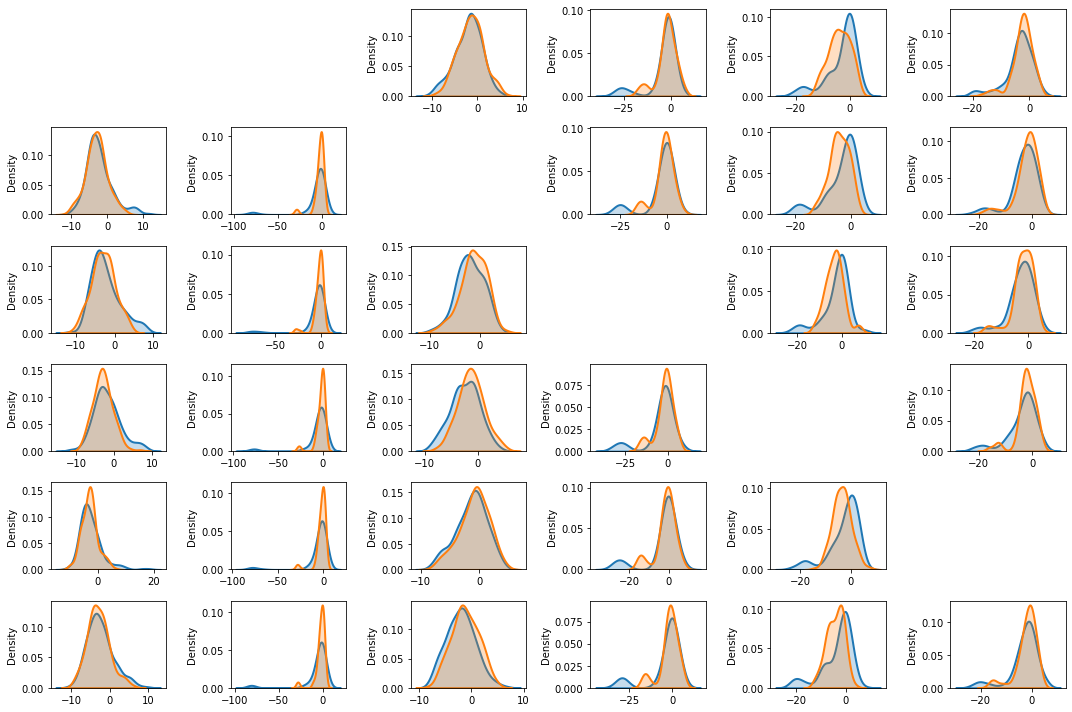

In [217]:
def plot_strength(V1, strength_stationary, strength_running, plot_self=False, filter_amp=20, output=False):
    transfer_ij = {-1:-1, 4:0, 5:1, 0:2, 1:3, 2:4, 3:5}
    probe_list = V1.selected_probes
    name_list = ['V1', 'LM', 'AL', 'RL', 'AM', 'PM']
    fontsize = 15
    filter_length = 0.1
    trial_length = V1.nt

    sns.reset_orig()
    # sns.set_theme()
    if output:
        plt.subplots(figsize=(6.9,4.6))
        SMALL_SIZE = 5
        MEDIUM_SIZE = 7
        BIGGER_SIZE = 8
        BIGGER_LW = 1
        SMALL_LW = 0.75
        utils.use_pdf_plot()
    else:
        plt.subplots(figsize=(15,10))
        BIGGER_SIZE = 15
        MEDIUM_SIZE = 15
        SMALL_SIZE = 10
        BIGGER_LW = 2
        SMALL_LW = 1.5
    
#     plt.subplots(figsize=(15,10))
    for i in range(len(probe_list)):
        for j in range(len(probe_list)):
            i_plot = transfer_ij[i]
            j_plot = transfer_ij[j]
            if i==j and (not plot_self):
                continue
            ax = plt.subplot(6, 6, i*6+j+1+1, frameon=True)
            filter_index = i_plot,j_plot
    #         print(filter_index)
            
            sns.kdeplot(strength_stationary[i_plot,j_plot], linewidth=2, fill=True)
            sns.kdeplot(strength_running[i_plot,j_plot], linewidth=2, fill=True)
            
            plt.tight_layout()
            # plt.grid()

plot_strength(V1, strength_stationary, strength_running, output=False)

In [218]:
from scipy.stats import ranksums
from scipy import stats

for i, target_probe in enumerate(probe_list):
    for j, input_probe in enumerate(probe_list):
        res = ranksums( strength_stationary[i,j], strength_running[i,j] )
        if res[1]<=0.01 and i!=j:
            print(f"{input_probe}->{target_probe}: {res[1]}")

probeC->probeA: 0.005477236142490041
probeF->probeA: 7.519110808338937e-05
probeC->probeB: 0.0017108009666888342
probeD->probeB: 0.002043501544733725
probeF->probeB: 5.441382594746293e-06
probeA->probeC: 0.007397122197564661
probeF->probeC: 2.9034981993815663e-05
probeF->probeD: 0.0006729538848661875
probeB->probeE: 0.006319390537551966
probeF->probeE: 0.0021978682820671235
probeC->probeF: 0.00046024222078107206
probeD->probeF: 0.0017566615198976664


# Each condition as a session

Tried: 
- using 'fix' function without time warping
- using 'fit_time_warping_baseline' function with trained peak times. 
- 

In [127]:
### Get the id of neurons that are classified as cross-pop
stimulus_condition_id = [275, 277, 246, 255, 272, 248, 283, 266, 274, 276, 286, 271, 268, 270]
cross_pop_list_all = {}
probe_list = V1.selected_probes
for target_probe in probe_list:
    cross_pop_list = []
    cross_pop_conditions = {}
    for neuron in membership[0].index:
        if membership[1].loc[neuron]['probe'] == target_probe:
            for i, member in enumerate(membership):
                if member.loc[neuron]['group_id'] >= 0:
                    if condition_ids[i] in stimulus_condition_id:
                        if neuron not in cross_pop_conditions:
                            cross_pop_list.append(neuron)
                            cross_pop_conditions[neuron] = [condition_ids[i]]
                        else:
                            cross_pop_conditions[neuron].append(condition_ids[i])
    major_cross_pop_list = []
    for neuron in cross_pop_list:
        if len(cross_pop_conditions[neuron])>= 1:
            major_cross_pop_list.append(neuron)
    cross_pop_list_all[target_probe] = major_cross_pop_list

In [128]:
spike_train_ind_dict = {}
for target_probe in probe_list:
    for neuron in cross_pop_list_all[target_probe]:
        # Get spike train of the neuron first
        spike_train_ind = np.zeros((V1.nt+V1.npadding, V1.spike_train.shape[1]))
        for itrial in range(V1.spike_train.shape[1]):
            spike_train_ind[:,itrial] = V1.spike_train.loc[neuron, V1.spike_train.columns[itrial]]
        spike_train_ind_dict[neuron] = spike_train_ind
    

In [202]:
from collections import defaultdict
strength_stationary = defaultdict(list)
strength_running = defaultdict(list)
probe_list = V1.selected_probes
condition_list = V1.presentation_table['stimulus_condition_id'].values

minimum_trial = 1
USE_WARPING = False
max_iter = 3
tau = 15
coupling_filter_params = {'peaks_max':20.2, 'num':3, 'nonlinear':0.5}
num_basis_baseline = 15
penalty = 1e2

for i, current_condition in enumerate(stimulus_condition_id):
    
    current_membership = membership[np.where(np.array(condition_ids)==current_condition)[0][0]]
    trials_in_this_condition = condition_list==current_condition
    cross_pop_list_all = {}
    
    for target_probe in probe_list:
        cross_pop_list = []
        cross_pop_conditions = {}
        for neuron in current_membership.index:
            if current_membership.loc[neuron]['probe'] == target_probe and \
                current_membership.loc[neuron]['group_id'] == 0:
                    cross_pop_list.append(neuron)
        cross_pop_list_all[target_probe] = cross_pop_list
    
    for i, target_probe in tqdm(enumerate(probe_list)):
        for neuron in cross_pop_list_all[target_probe]:

            ### Stationary
            select_trials = np.logical_and(V1.stationary_trial_index, trials_in_this_condition)
            if select_trials.sum()>=minimum_trial and select_trials.sum()<=15-minimum_trial:
                model_stationary = GLM.PP_GLM(dataset=V1, 
                                       select_trials=select_trials, 
                                       membership=membership, 
                                       condition_ids=condition_ids)
                model_stationary.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=False)
                for j, input_probe in enumerate(probe_list):
                    for input_neuron in cross_pop_list_all[input_probe]:
                        spike_train_ind = spike_train_ind_dict[input_neuron]
                        model_stationary.add_effect('coupling', spike_train_ind, 
                                                    **coupling_filter_params, apply_no_penalty=False)
                model_stationary.add_effect('trial_coef')
                spike_train_ind = spike_train_ind_dict[neuron]
                if USE_WARPING:
                    model_stationary.fit_time_warping_baseline(spike_train_ind, 
                                           method='mine', 
                                           verbose=False, 
                                           penalty=penalty, 
                                           max_iter=max_iter,
                                           fix_shifts=fix_shifts_running_all[target_probe], 
                                           no_penalty_term_penalty=penalty)
                else:
                    model_stationary.fit(spike_train_ind, 
                                           method='mine', 
                                           verbose=False, 
                                           penalty=penalty, 
                                           no_penalty_term_penalty=penalty)
                filters = model_stationary.get_filter()
                k = 0
                for j, input_probe in enumerate(probe_list):
                    for input_neuron in cross_pop_list_all[input_probe]:
                        k += 1
                        strength = np.mean(filters[k])
                        strength_stationary[i,j].append(strength)

            ### Running
            select_trials = np.logical_and(V1.running_trial_index, trials_in_this_condition)
            if select_trials.sum()>=minimum_trial and select_trials.sum()<=15-minimum_trial:
                model_running = GLM.PP_GLM(dataset=V1, 
                                   select_trials=select_trials, 
                                   membership=membership, 
                                   condition_ids=condition_ids)
                model_running.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=False)
                for j, input_probe in enumerate(probe_list):
                    for input_neuron in cross_pop_list_all[input_probe]:
                        spike_train_ind = spike_train_ind_dict[input_neuron]
                        model_running.add_effect('coupling', spike_train_ind, 
                                                    **coupling_filter_params, apply_no_penalty=False)
                model_running.add_effect('trial_coef')
                spike_train_ind = spike_train_ind_dict[neuron]
                if USE_WARPING:
                    model_running.fit_time_warping_baseline(spike_train_ind, 
                                       method='mine', 
                                       verbose=False, 
                                       max_iter=max_iter,
                                       fix_shifts=fix_shifts_running_all[target_probe], 
                                       penalty=penalty, 
                                       no_penalty_term_penalty=penalty)
                else:
                    model_running.fit(spike_train_ind, 
                                           method='mine', 
                                           verbose=False, 
                                           penalty=penalty, 
                                           no_penalty_term_penalty=penalty)
                filters = model_running.get_filter()
                k = 0
                for j, input_probe in enumerate(probe_list):
                    for input_neuron in cross_pop_list_all[input_probe]:
                        k += 1
                        strength = np.mean(filters[k])
                        strength_running[i,j].append(strength)
        

6it [00:23,  3.99s/it]
6it [00:29,  4.95s/it]
6it [00:39,  6.64s/it]
6it [00:33,  5.52s/it]
6it [00:26,  4.39s/it]
6it [00:17,  2.90s/it]
6it [00:24,  4.16s/it]
6it [00:24,  4.04s/it]
6it [00:26,  4.37s/it]
6it [00:15,  2.58s/it]
6it [00:22,  3.82s/it]
6it [00:30,  5.15s/it]
6it [00:26,  4.43s/it]
6it [00:37,  6.18s/it]


In [205]:
from scipy.stats import ranksums
from scipy import stats

for i, target_probe in enumerate(probe_list):
    for j, input_probe in enumerate(probe_list):
        res = ranksums( strength_stationary[i,j], strength_running[i,j] )
        if res[1]<=0.01 and i!=j:
            print(f"{input_probe}->{target_probe}: {res[1]}")

probeB->probeA: 4.700920143119466e-11
probeC->probeA: 9.58038200877527e-05
probeE->probeA: 3.593951581527594e-17
probeF->probeA: 1.6024729729728438e-11
probeA->probeB: 6.127630221338278e-49
probeC->probeB: 0.00020314357766386182
probeD->probeB: 3.3814363475683605e-05
probeE->probeB: 6.324544397103733e-25
probeF->probeB: 3.8800389813128545e-12
probeA->probeC: 5.73486040387407e-60
probeB->probeC: 2.5232558866131847e-23
probeD->probeC: 5.545513823563236e-06
probeE->probeC: 1.0756480870753308e-27
probeF->probeC: 1.1662165615957527e-17
probeA->probeD: 7.293639520750678e-41
probeB->probeD: 8.265796856942954e-11
probeE->probeD: 9.639681974158384e-17
probeF->probeD: 1.2548177431734692e-09
probeA->probeE: 1.9384588434239994e-28
probeB->probeE: 3.65985830730708e-07
probeC->probeE: 0.0013848692147011962
probeD->probeE: 0.00392385928192221
probeF->probeE: 0.0006082458603070606
probeA->probeF: 1.679999811190399e-83
probeB->probeF: 8.966471690380277e-38
probeC->probeF: 1.5554418110711293e-11
probeD-

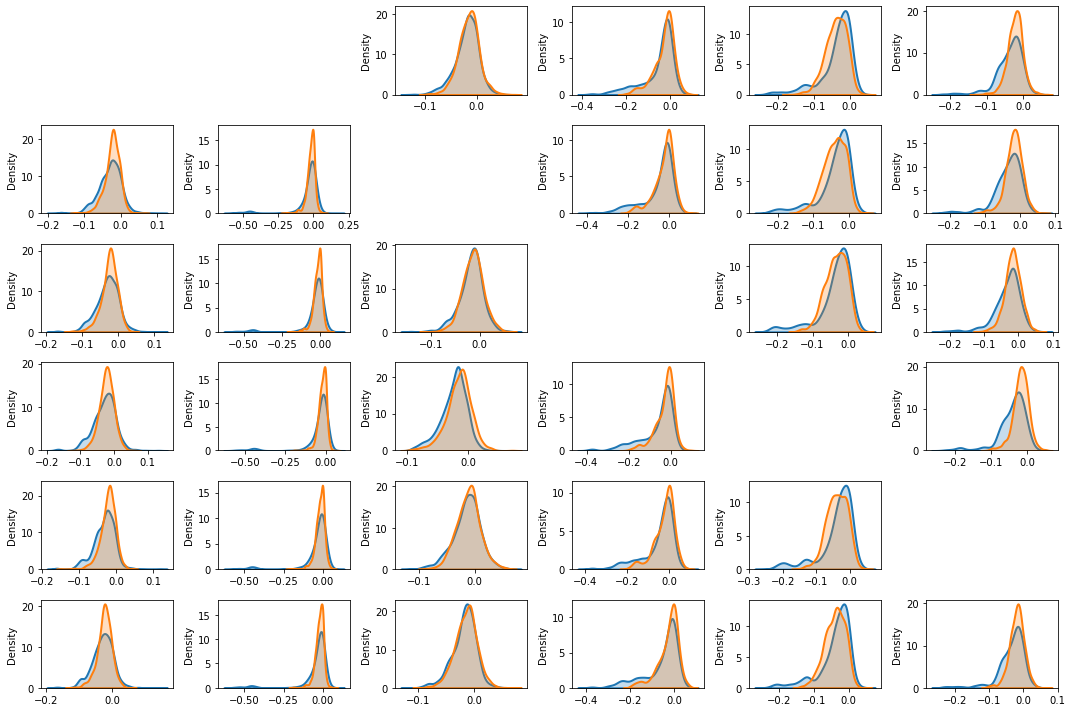

In [206]:
def plot_strength(V1, strength_stationary, strength_running, plot_self=False, filter_amp=20, output=False):
    transfer_ij = {-1:-1, 4:0, 5:1, 0:2, 1:3, 2:4, 3:5}
    probe_list = V1.selected_probes
    name_list = ['V1', 'LM', 'AL', 'RL', 'AM', 'PM']
    fontsize = 15
    filter_length = 0.1
    trial_length = V1.nt

    sns.reset_orig()
    # sns.set_theme()
    if output:
        plt.subplots(figsize=(6.9,4.6))
        SMALL_SIZE = 5
        MEDIUM_SIZE = 7
        BIGGER_SIZE = 8
        BIGGER_LW = 1
        SMALL_LW = 0.75
        utils.use_pdf_plot()
    else:
        plt.subplots(figsize=(15,10))
        BIGGER_SIZE = 15
        MEDIUM_SIZE = 15
        SMALL_SIZE = 10
        BIGGER_LW = 2
        SMALL_LW = 1.5
    
#     plt.subplots(figsize=(15,10))
    for i in range(len(probe_list)):
        for j in range(len(probe_list)):
            i_plot = transfer_ij[i]
            j_plot = transfer_ij[j]
            if i==j and (not plot_self):
                continue
            ax = plt.subplot(6, 6, i*6+j+1+1, frameon=True)
            filter_index = i_plot,j_plot
    #         print(filter_index)
            
            sns.kdeplot(strength_stationary[i_plot,j_plot], linewidth=2, fill=True)
            sns.kdeplot(strength_running[i_plot,j_plot], linewidth=2, fill=True)
            
            plt.tight_layout()
            # plt.grid()

plot_strength(V1, strength_stationary, strength_running, output=False)